# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3d Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

In [1]:
# Import libraries
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import h5py
import pandas as pd

tf.random.set_seed(1234)


2022-12-01 00:45:22.783596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 00:45:23.688101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-01 00:45:23.688178: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-01 00:45:23.688185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

### Load MNIST Dataset

In [3]:
DATADIR = '../data/multimodal/mnist3d/'

In [4]:
# with h5py.File(DATADIR + 'full_dataset_vectors.h5', 'r') as dataset:
#     X_train = dataset['X_train'][:]
#     X_test = dataset['X_test'][:]
#     y_train = dataset['y_train'][:]
#     y_test = dataset['y_test'][:]

In [5]:
noOfpoints = 2048
BATCH_SIZE = 32
run_type = 'demo'
# run_type = 'full'

NUM_CLASSES = 10
NUM_POINTS = noOfpoints

In [6]:
with h5py.File(DATADIR + 'train_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_train_2d = []
    x_train_3d = []
    y_train = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_train_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_train_3d.append(pointCloud)

        # Ssaving labels...
        y_train.append(sample.attrs['label'])

# converting to np array...
x_train_2d = np.stack(x_train_2d)
x_train_3d = np.stack(x_train_3d)
y_train = np.array(y_train)

In [7]:
with h5py.File(DATADIR + 'test_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_test_2d = []
    x_test_3d = []
    y_test = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_test_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_test_3d.append(pointCloud)

        # Ssaving labels...
        y_test.append(sample.attrs['label'])

# converting to np array...
x_test_2d = np.stack(x_test_2d)
x_test_3d = np.stack(x_test_3d)
y_test = np.array(y_test)

In [8]:
# Creating dataset for mnist 3D data...

In [9]:
# adding extra...

total_training_samples = x_train_3d.shape[0]
total_testing_samples = x_test_3d.shape[0]

random_trainig_indices = np.arange(total_training_samples)
np.random.shuffle(random_trainig_indices)

random_testing_indices = np.arange(total_testing_samples)
np.random.shuffle(random_testing_indices)


print(f"No of training samples: {x_train_3d.shape[0]}")
print(f"No of testing samples: {x_test_3d.shape[0]}")


if run_type == 'demo':
    demo_training_samples = 100
    demo_testing_samples = 100

    random_trainig_indices = random_trainig_indices[0:demo_training_samples]
    random_testing_indices = random_testing_indices[0:demo_testing_samples]

train_points_selected = x_train_3d[random_trainig_indices]
train_labels_selected = y_train[random_trainig_indices]

test_points_selected = x_test_3d[random_testing_indices]
test_labels_selected = y_test[random_testing_indices]

print("After updating...")
print(f"No of training samples: {train_points_selected.shape[0]}")
print(f"No of testing samples: {test_points_selected.shape[0]}")
print("Done...!")





No of training samples: 5000
No of testing samples: 1000
After updating...
No of training samples: 100
No of testing samples: 100
Done...!


In [10]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(x_test_3d)).batch(BATCH_SIZE)

2022-12-01 00:45:57.584809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 00:45:57.622205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 00:45:57.622495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 00:45:57.623767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [11]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [12]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

 We can then define a general function to build T-net layers.


In [13]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [14]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [15]:
model

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [18]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)


Epoch 1/10
157/157 [==============================] - 72s 400ms/step - loss: 1.8029 - sparse_categorical_accuracy: 0.8170 - val_loss: 3.6021 - val_sparse_categorical_accuracy: 0.7040
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 1.6749 - sparse_categorical_accuracy: 0.8564

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


1/1 [==============================] - 0s 385ms/step


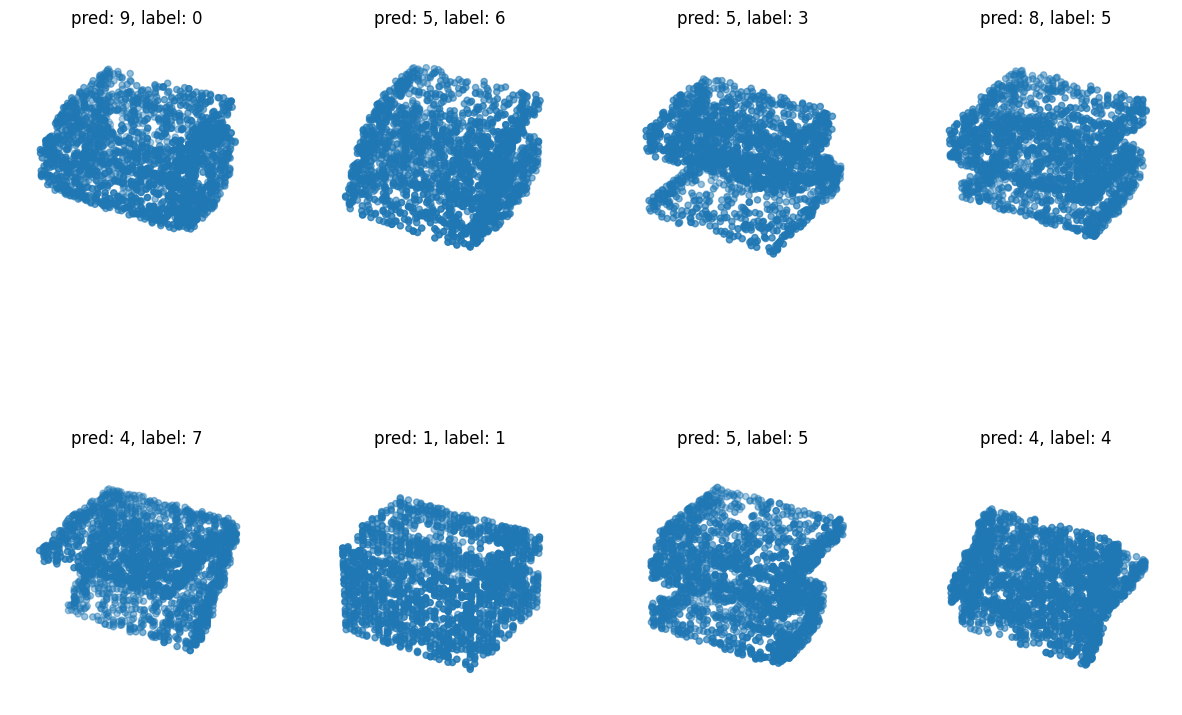

In [17]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels.numpy()[i]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
# def augment(points, label):
#     # jitter points
#     points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
#     # shuffle points
#     points = tf.random.shuffle(points)
#     return points, label


# train_dataset = tf.data.Dataset.from_tensor_slices((train_points_selected, train_labels_selected))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_points_selected, test_labels_selected))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [ ]:
np.stack(x_train_2d).shape

In [ ]:
np.stack(x_train_3d).shape

In [ ]:
x_train_2d.max()

In [ ]:
np.stack(X_output)

In [ ]:
np.array([x_train_3d[0][:], x_train_3d[1][:], x_train_3d[2][:]])

In [ ]:
np.array([x_train_3d[0], x_train_3d[1], x_train_3d[2]]).shape

In [ ]:
x_train_3d_cut = x_train_3d[0:10]

In [ ]:
x_train_3d_cut

In [ ]:
np.array([x_train_3d_each, x_train_3d_each, x_train_3d_each]).shape

In [ ]:
import pandas as pd
x_train_3d_s = []

for x_train_3d_each in x_train_3d_cut:

    x_train_3d_s.append(pd.DataFrame(x_train_3d_each).values)

    # points_s = []
    
    # for points in x_train_3d_each:
    #     xs = []
    #     for x in points:
    #         xs.append(x)

    #     points_s.append(xs)
    
    # x_train_3d_s.append(points_s)

# x_train_3d_s = np.array(x_train_3d_s)
# x_train_3d_s.shape

In [ ]:
np.array(x_train_3d_s)

In [ ]:
np.array(x_train_3d_s).shape

In [ ]:
x_train_3d_s = []
x_train_3d_s.append(points_s)
x_train_3d_s.append(points_s)
x_train_3d_s.append(points_s)
np.array(x_train_3d_s).shape

In [ ]:
np.array([points_s, points_s, points_s]).shape

In [ ]:
x_train_3d_s

In [ ]:
xs

In [ ]:
points_s

In [ ]:
np.array(x_train_3d_s)

In [ ]:
np.__version__

In [ ]:
np.array([(x.tolist()) for x in x_train_3d[0:10]])

In [ ]:
np.array(pd.DataFrame(x_train_3d).values)

In [ ]:
x_train_3d.shape


In [ ]:
type(x_train_3d)

In [ ]:
newarray = np.dstack(x_train_3d)
newarray.shape

In [ ]:
x_train_2d = np.array([])
x_train_2d = np.vstack(x_train_2d, np.random.randn(5,5))

In [ ]:
np.array(x_train_3d[0:10]) #, dtype= float)

In [ ]:
with h5py.File(DATADIR + 'test_point_clouds.h5', 'r') as points_dataset:

    # List...
    x_test_2d = []
    x_test_3d = []
    y_test = [] 

    # Iterate over the 2D and 3D points...
    for key, sample in points_dataset.items():
        x_test_2d.append(sample['img'][:])
        x_test_3d.append(sample['points'][:])
        y_test.append(sample.attrs['label'])


print(len(x_test_2d))

In [ ]:
### Visualize a pair of data points - Image and 3D points

image = x_train_2d[0]
points = x_train_3d[0][0::100]
label = y_train[0]

# fig, axs = plt.subplots(2, 1, figsize=(10, 5))
fig = plt.figure(figsize=(10,5))
# Image plot
ax = fig.add_subplot(211)
ax.imshow(image)

# Points plot
ax = fig.add_subplot(222, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(0,20)
plt.show()

### Code for CNN-based classification for MNIST Dataset
